In [1]:
# Imports
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import datetime
import platform

print(f"""
Python version: {platform.python_version}
Tensorflow version: {tf.__version__}
Keras version: {tf.keras.__version__}
""")

2023-06-04 12:08:38.810711: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-04 12:08:38.851156: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-04 12:08:38.851970: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 12:08:39.665095: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


ModuleNotFoundError: No module named 'seaborn'

## Configuring Tensorboard

We will use Tensorboard to debug the model later.

In [2]:
# Load the Tensorboard notebook extension
# %reload_ext tensorboard
%load_ext tensorboard

In [3]:
# Clear any logs from previous runs
!rm -rf ./.logs/

## Load the data

The training dataset consists of 60000 28X28px images of hand-written digits from `0` to `9`.
<br>
The test dataset consists of 10000 28X28px images.

In [4]:
mnist_dataset = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()

In [5]:
print(f"""
x_train: {x_train.shape}
y_train: {y_train.shape}
x_test: {x_test.shape}
y_test: {y_test.shape}
""")


x_train: (60000, 28, 28)
y_train: (60000,)
x_test: (10000, 28, 28)
y_test: (10000,)



In [6]:
# Save image parameters to the constansts that will use later for data re-shaping and for model training
(_, IMG_WIDTH, IMG_HEIGHT) = x_train.shape
IMG_CHANNELS = 1

print(f"""
Image width: {IMG_WIDTH}
Image height: {IMG_HEIGHT}
Image channels: {IMG_CHANNELS}
""")


Image width: 28
Image height: 28
Image channels: 1



## Explore tha data

Here is how each image in the dataset looks like. It is a 28x28 matrix of integers (from `0` to `255`). Each integer represents a color of a pixel.

In [7]:
pd.DataFrame(x_train[0])

NameError: name 'pd' is not defined

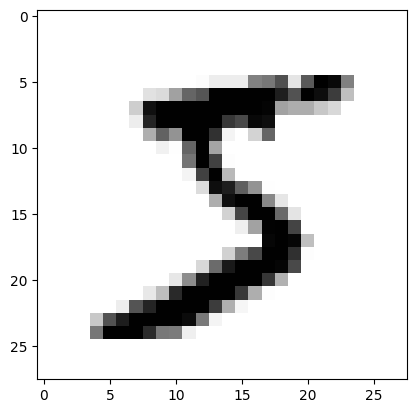

In [8]:
# This matrix of numbers may be draw as follows:
plt.imshow(x_train[0], cmap=plt.cm.binary)
plt.show()

In [9]:
# Let's print some more training examples to get the feeling of how the digits were written
numbers_to_display = 25
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(10, 10))

for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])    
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

NameError: name 'math' is not defined

## Reshaping the data

In order to use convolution layers we need to reshape our data and add a color channel to it. As you've noticed currently every digit has a shape of `(28, 28)` which means that it is a 28x28 matrix of color values form `0` to `255`. We need to reshape it to `(28, 28, 1)` shape so that each pixel potentially may have multiple channels (like Red, Green and Blue).

In [10]:
(x_train.shape[0],
    IMG_WIDTH,
    IMG_HEIGHT,
    IMG_CHANNELS)

(60000, 28, 28, 1)

In [11]:
x_train_with_channels = x_train.reshape(
    x_train.shape[0],
    IMG_WIDTH,
    IMG_HEIGHT,
    IMG_CHANNELS
)

x_test_with_channels = x_test.reshape(
    x_test.shape[0],
    IMG_WIDTH,
    IMG_HEIGHT,
    IMG_CHANNELS
)

In [12]:
print('x_train_with_channels: ', x_train_with_channels.shape)
print('x_test_with_channels: ', x_test_with_channels.shape)

x_train_with_channels:  (60000, 28, 28, 1)
x_test_with_channels:  (10000, 28, 28, 1)


In [14]:
print(x_train_with_channels[0].shape)

(28, 28, 1)


## Normalize the data

Here we're just trying to move from values range of `[0...255]` to `[0...1]`

In [15]:
x_train_normalized = x_train_with_channels / 255
x_test_normalized = x_test_with_channels / 255

In [17]:
x_train_normalized[0]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

In [18]:
x_train_normalized[0].shape

(28, 28, 1)

# Build the model

Build the model

We will use [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential?version=stable) Keras model.

Then we will have two pairs of [Convolution2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D?version=stable) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D?version=stable) layers. The MaxPooling layer acts as a sort of downsampling using max values in a region instead of averaging.

After that we will use [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten?version=stable) layer to convert multidimensional parameters to vector.

The las layer will be a [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense?version=stable) layer with `10` [Softmax](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax?version=stable) outputs. The output represents the network guess. The 0-th output represents a probability that the input digit is `0`, the 1-st output represents a probability that the input digit is `1` and so on...

### Layers explain

`Convolution2D (Conv2D):`
A camada Convolution2D é uma camada de convolução 2D usada em redes neurais convolucionais (ConvNets). Ela é frequentemente usada para extrair características de imagens. A convolução 2D envolve a aplicação de um conjunto de filtros em uma imagem de entrada, onde cada filtro é responsável por detectar padrões específicos. Os filtros percorrem a imagem com uma janela deslizante, multiplicam seus valores pelos valores correspondentes da imagem e somam os resultados. Isso cria um mapa de características, que destaca as regiões relevantes da imagem.

`MaxPooling2D:`
A camada MaxPooling2D é usada para reduzir a dimensionalidade dos mapas de características gerados pelas camadas de convolução. Ela opera em janelas deslizantes, selecionando o valor máximo em cada região. Isso reduz o tamanho espacial dos mapas de características, preservando as características mais importantes. A redução da dimensionalidade ajuda a diminuir a quantidade de parâmetros na rede neural e a extrair características mais robustas.

`Flatten:`
A camada Flatten é usada para "achatar" os dados de entrada em um vetor unidimensional. Ela converte uma matriz de entrada multidimensional em um vetor, que pode ser usado como entrada para uma camada densa (totalmente conectada). Essa camada é comumente usada para conectar as camadas de convolução/max pooling às camadas densas finais da rede neural.

`Dense:`
A camada Dense é uma camada de rede neural totalmente conectada, em que cada neurônio na camada anterior está conectado a cada neurônio na camada seguinte. Ela é responsável por computar combinações lineares dos valores de entrada e aplicar uma função de ativação a essas combinações. A camada Dense é usada para aprendizado e tomada de decisão com base nos recursos extraídos pelas camadas anteriores.

`Dropout:`
A camada Dropout é usada para combater o overfitting em redes neurais. Ela desativa aleatoriamente um número especificado de neurônios durante o treinamento em cada passagem. Isso ajuda a prevenir a dependência excessiva de neurônios específicos e torna a rede neural mais robusta e menos suscetível a overfitting. O Dropout regulariza a rede, forçando-a a aprender representações redundantes dos dados, o que geralmente melhora o desempenho em dados de teste não vistos.

In [ ]:
# Create model
model = tf.keras.models.Sequential()

In [ ]:
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout

## Add layers

### Convolution 2D

- `input_shape`: Este parâmetro define a forma de entrada dos dados para a camada convolucional. No caso dado, a forma de entrada é (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), onde IMG_WIDTH representa a largura da imagem de entrada, IMG_HEIGHT representa a altura da imagem de entrada e IMG_CHANNELS representa o número de canais de cor da imagem (geralmente 3 para imagens RGB).
<br><br>
- `kernel_size`: Este parâmetro especifica o tamanho do kernel ou filtro convolucional. No código fornecido, o valor é definido como 5, o que significa que o kernel convolucional terá uma dimensão de 5x5.
<br><br>
- `filters`: Este parâmetro indica o número de filtros convolucionais a serem aplicados na camada. No código dado, o valor é definido como 8, o que significa que haverá 8 filtros convolucionais.
<br><br>
- `strides`: Este parâmetro define o passo da convolução, ou seja, quantos pixels o filtro se move a cada passo. No código fornecido, o valor é definido como 1, o que significa que o filtro se moverá 1 pixel por vez.
<br><br>
- `activation`: Este parâmetro especifica a função de ativação a ser aplicada após a operação de convolução. No código dado, a função tf.keras.activations.relu é usada, que representa a ativação ReLU (Rectified Linear Unit), que é comumente usada para introduzir não-linearidade nas redes neurais convolucionais.
<br><br>
- `kernel_initializer`: Este parâmetro define o método de inicialização dos pesos do kernel convolucional. No código fornecido, tf.keras.initializers.VarianceScaling() é usado como inicializador de pesos, que inicializa os pesos de acordo com uma escala de variação, o que ajuda a melhorar a convergência durante o treinamento da rede.

In [ ]:
# Convolution 2D
model.add(Convolution2D(
    input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS),
    kernel_size=5,
    filters=8,
    strides=1,
    activation=tf.keras.activations.relu,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

### MaxPooling2D

- `pool_size`: Este parâmetro define o tamanho da janela de pooling. No código fornecido, o valor é definido como (2, 2), o que significa que será usada uma janela de pooling 2x2.
<br><br>
- `strides`: Este parâmetro define o passo da janela de pooling. No código fornecido, o valor é definido como (2, 2), o que significa que a janela de pooling será movida 2 pixels verticalmente e 2 pixels horizontalmente a cada passo.

In [ ]:
model.add(MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

In [ ]:
model.add(Convolution2D(
    kernel_size=5,
    filters=16,
    strides=1,
    activation=tf.keras.activations.relu,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

In [ ]:
model.add(MaxPooling2D(
    pool_size=(2, 2),
    strides=(2, 2)
))

In [ ]:
model.add(Flatten())

In [ ]:
model.add(Dropout(.2))

### Dense

- `units`: Este parâmetro define o número de unidades ou neurônios na camada densa. No código fornecido, o valor é definido como 10, o que significa que a camada densa terá 10 neurônios.
<br><br>
- `activation`: Este parâmetro especifica a função de ativação a ser aplicada às saídas da camada densa. No código dado, a função tf.keras.activations.softmax é usada como função de ativação. A função softmax é comumente usada na camada de saída de classificação multiclasse para normalizar as saídas em uma distribuição de probabilidade sobre as diferentes classes.
<br><br>
- `kernel_initializer`: Este parâmetro define o método de inicialização dos pesos da camada densa. No código fornecido, tf.keras.initializers.VarianceScaling() é usado como inicializador de pesos, que inicializa os pesos de acordo com uma escala de variação, assim como na camada de convolução.

In [ ]:
model.add(Dense(
    units=10,
    activation=tf.keras.activations.softmax,
    kernel_initializer=tf.keras.initializers.VarianceScaling()
))

In [ ]:
# Here is our model summary so far
model.summary()

In order to plot the model the `graphviz` should be installed. For Mac OS it may be installed using `brew` like `brew install graphviz`.

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True, 
    show_layer_names=True
)

## Compile the model

- `optimizer`: Esse parâmetro especifica o otimizador a ser usado durante o treinamento do modelo. No código fornecido, adam_optimizer é usado como otimizador. O adam_optimizer provavelmente é uma instância da classe tf.keras.optimizers.Adam, que é uma implementação do algoritmo de otimização Adam. O otimizador Adam é amplamente utilizado em redes neurais devido à sua eficiência e bons resultados em muitos cenários de aprendizado profundo.
<br><br>
- `loss`: Este parâmetro especifica a função de perda a ser usada durante o treinamento do modelo. No código fornecido, tf.keras.losses.sparse_categorical_crossentropy é usado como função de perda. Essa função de perda é comumente usada em tarefas de classificação multiclasse, onde as classes são representadas como rótulos inteiros (por exemplo, 0, 1, 2, ...) em vez de codificação one-hot.
<br><br>
- `metrics`: Esta lista especifica as métricas a serem avaliadas durante o treinamento e teste do modelo. No código fornecido, a lista contém apenas uma métrica, que é 'accuracy', indicando que a precisão será calculada durante o treinamento e teste do modelo.

In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [ ]:
log_dir = f'.logs/fit/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1
)

In [ ]:
training_history = model.fit(
    x_train_normalized,
    y_train,
    epochs=10,
    validation_data=(x_test_normalized, y_test),
    callbacks=[tensorboard_callback]
)

Let's see how the loss function was changing during the training. We expect it to get smaller and smaller on every next epoch.

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(training_history.history['loss'], label='training set')
plt.plot(training_history.history['val_loss'], label='test set')
plt.legend()

In [ ]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(training_history.history['accuracy'], label='training set')
plt.plot(training_history.history['val_accuracy'], label='test set')
plt.legend()

## Evaluate model accuracy

We need to compare the accuracy of our model on **training** set and on **test** set. We expect our model to perform similarly on both sets. If the performance on a test set will be poor comparing to a training set it would be an indicator for us that the model is overfitted and we have a "high variance" issue.

### Training set accuracy

In [ ]:
%%capture
train_loss, train_accuracy = model.evaluate(x_train_normalized, y_train)

In [ ]:
print('Training loss: ', train_loss)
print('Training accuracy: ', train_accuracy)

### Test set accuracy

In [ ]:
%%capture 
validation_loss, validation_accuracy = model.evaluate(x_test_normalized, y_test)

In [ ]:
print('Validation loss: ', validation_loss)
print('Validation accuracy: ', validation_accuracy)

## Save the model

We will save the entire model to a `HDF5` file. The `.h5` extension of the file indicates that the model shuold be saved in Keras format as HDF5 file. To use this model on the front-end we will convert it (later in this notebook) to Javascript understandable format (`tfjs_layers_model` with .json and .bin files) using [tensorflowjs_converter](https://www.tensorflow.org/js/tutorials/conversion/import_saved_model) as it is specified in the [main README](https://github.com/trekhleb/machine-learning-experiments).

In [ ]:
model_name = 'digits_recognition_cnn.h5'
model.save(model_name, save_format='h5')

In [ ]:
loaded_model = tf.keras.models.load_model(model_name)

## Use the model (do predictions)

To use the model that we've just trained for digits recognition we need to call `predict()` method.

In [ ]:
prediction_one_hot = loaded_model.predict([x_test_normalized])

In [ ]:
print('predictions_one_hot: ', prediction_one_hot.shape)

Each prediction consists of 10 probabilities (one for each number from `0` to `9`). We need to pick the digit with the highest probability since this would be a digit that our model most confident with.

In [ ]:
pd.DataFrame(prediction_one_hot)

In [ ]:
predictions = np.argmax(prediction_one_hot, axis=1)
pd.DataFrame(predictions)

In [ ]:
print(predictions[0])

In [ ]:
plt.imshow(x_test_normalized[0].reshape(IMG_WIDTH, IMG_HEIGHT), cmap=plt.cm.binary)
plt.show()

We see that our model made a correct prediction and it successfully recognized digit `7`. Let's print some more test examples and correspondent predictions to see how model performs and where it does mistakes.

In [ ]:
numbers_to_display = 196
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(15, 15))

for plot_index in range(numbers_to_display):    
    predicted_label = predictions[plot_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    color_map = 'Greens' if predicted_label == y_test[plot_index] else 'Reds'
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(x_test_normalized[plot_index].reshape((IMG_WIDTH, IMG_HEIGHT)), cmap=color_map)
    plt.xlabel(predicted_label)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

## Plotting a confusion matrix

[Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) shows what numbers are recognized well by the model and what numbers the model usually confuses to recognize correctly. You may see that the model performs really well but sometimes (28 times out of 10000) it may confuse number `5` with `3` or number `2` with `3`.

In [ ]:
confusion_matrix = tf.math.confusion_matrix(y_test, predictions)
f, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.5,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

## Debugging the model with TensorBoard

[TensorBoard](https://www.tensorflow.org/tensorboard) is a tool for providing the measurements and visualizations needed during the machine learning workflow. It enables tracking experiment metrics like loss and accuracy, visualizing the model graph, projecting embeddings to a lower dimensional space, and much more.

In [ ]:
%tensorboard --logdir .logs/fit

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/digits_recognition_cnn/digits_recognition_cnn.h5 \
  ./demos/public/models/digits_recognition_cnn
```

You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.